In [327]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [328]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt

from KAGGLE_NLP_with_disaster_tweets.model import attention_model
from KAGGLE_NLP_with_disaster_tweets.data_preparation.utils import DataPipeline, BatchPipeline

In [329]:
train_file_name = 'train.csv'
test_file_name = 'test.csv'
sample_submission_file_name = 'sample_submission.csv'
vocabulary_size = 15000

data_pipeline = DataPipeline(train_file_name, test_file_name, sample_submission_file_name, output_sequence_length=30, vocabulary_size=vocabulary_size, glove_embedding_dim=100)
dataset = data_pipeline.prepare_dataset(include_cols=["location", "keyword"], apply_preprocessing=True)

Getting the file: ../data/train.csv
Dataframe size before eliminating too short texts: 7613
Dataframe size after eliminating too short texts: 7462
         id keyword location  \
0         1                    
1         4                    
2         5                    
3         6                    
4         7                    
...     ...     ...      ...   
7608  10869                    
7609  10870                    
7610  10871                    
7611  10872                    
7612  10873                    

                                                   text  target  
0     our deeds are the reason of this earthquake ma...       1  
1                 forest fire near la ronge sask canada       1  
2     all residents asked to shelter in place are be...       1  
3      people receive wildfires evacuation orders in...       1  
4     just got sent this photo from ruby alaska as s...       1  
...                                                 ...     ...  
7608  

In [330]:
print(data_pipeline.input_vectorizer.get_vocabulary()[:10])

['', '[UNK]', 'url', 'the', 'user', 'a', 'in', 'to', 'of', 'i']


In [331]:
model = None
use_glove_embeddings = True

if use_glove_embeddings:
    model = attention_model.Classifier(
        model_dim=data_pipeline.glove_embedding_dim,
        feed_forward_dim=256,
        num_heads=2,
        vocab_size=data_pipeline.vocabulary_size,
        n_labels=2,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        embeddings_initializer=data_pipeline.build_embeddings_initializer(),
        dropout_rate=0.5)
else:
    model = attention_model.Classifier(
        model_dim=128,
        feed_forward_dim=256,
        num_heads=2,
        vocab_size=data_pipeline.vocabulary_size,
        n_labels=2,
        maximum_position_encoding=data_pipeline.input_vectorizer.get_config()["output_sequence_length"],
        dropout_rate=0.5)

Found 1193514 word vectors 

Converted 11456 words, and missed 3544 words.


In [332]:
batch_pipeline = BatchPipeline(dataset=dataset, batch_size=16)

In [333]:
import tensorflow as tf
from official.nlp import optimization

lr = 1e-4
epochs = 10
warmup_ratio = 0.1

num_train_steps = epochs*len(list(batch_pipeline.train_dataset.as_numpy_iterator()))
num_warmup_steps = round(warmup_ratio* num_train_steps)

optimizer = optimization.create_optimizer(init_lr=lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [334]:
model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

## Sanity Check: Overfit the model

In [335]:
debugging_dataset = dataset.take(2).batch(2)

In [336]:
model.fit(debugging_dataset, validation_data=debugging_dataset, epochs=10)

Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 0.6751 - accuracy: 0.5000 - val_loss: 0.6915 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 0s 187ms/step - loss: 0.7489 - accuracy: 0.5000 - val_loss: 0.6910 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 0s 164ms/step - loss: 0.6672 - accuracy: 0.5000 - val_loss: 0.6902 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 0s 183ms/step - loss: 0.6954 - accuracy: 0.5000 - val_loss: 0.6889 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 0s 163ms/step - loss: 0.6879 - accuracy: 0.5000 - val_loss: 0.6872 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 0s 161ms/step - loss: 0.6793 - accuracy: 1.0000 - val_loss: 0.6851 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 0s 178ms/step - loss: 0.6329 - accuracy: 1.0000 - val_loss: 0.6826 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=======

## Train the model

In [337]:
res = model.fit(batch_pipeline.train_dataset, validation_data=batch_pipeline.validation_dataset, epochs=20)

Epoch 1/20
279/279 [==============================] - 5s 16ms/step - loss: 0.5971 - accuracy: 0.6808 - val_loss: 0.4902 - val_accuracy: 0.7762
Epoch 2/20
279/279 [==============================] - 4s 15ms/step - loss: 0.4757 - accuracy: 0.7888 - val_loss: 0.4676 - val_accuracy: 0.7890
Epoch 3/20
279/279 [==============================] - 4s 14ms/step - loss: 0.4463 - accuracy: 0.8098 - val_loss: 0.4690 - val_accuracy: 0.7997
Epoch 4/20
279/279 [==============================] - 4s 14ms/step - loss: 0.4358 - accuracy: 0.8129 - val_loss: 0.4693 - val_accuracy: 0.8044
Epoch 5/20
279/279 [==============================] - 4s 13ms/step - loss: 0.4256 - accuracy: 0.8136 - val_loss: 0.4721 - val_accuracy: 0.8044
Epoch 6/20
279/279 [==============================] - 5s 16ms/step - loss: 0.4214 - accuracy: 0.8156 - val_loss: 0.4740 - val_accuracy: 0.8071
Epoch 7/20
279/279 [==============================] - 4s 14ms/step - loss: 0.4131 - accuracy: 0.8257 - val_loss: 0.4704 - val_accuracy: 0.8071

## Visualize accuracy and loss

In [338]:
history = res.history

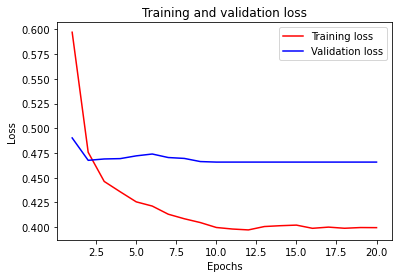

In [339]:
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

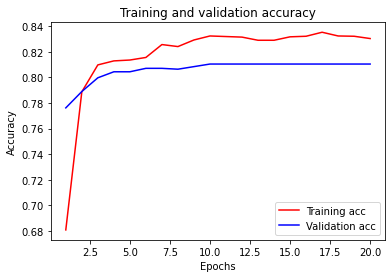

In [340]:
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()